In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

from functools import reduce
from datetime import date, timedelta

from Portfolio import Portfolio, SimplifiedPortfolio
from Portfolio import PortfolioOptimization, ConstrainedPortfolioOptimization

import yfinance as yf

In [2]:
START_DATE = date(2017, 1, 5)
END_DATE = date(2021, 6, 10)

my_holdings = {'CBA.AX': 10, 'NAB.AX': 10, 'MQG.AX': 10}
asx_portfolio = {'^AXJO': 1}

my_portfolio = Portfolio(my_holdings, start=START_DATE, end=END_DATE, name='Bank Portfolio')
asx_portfolio = Portfolio(asx_portfolio, start=START_DATE, end=END_DATE, name='ASX Portfolio')

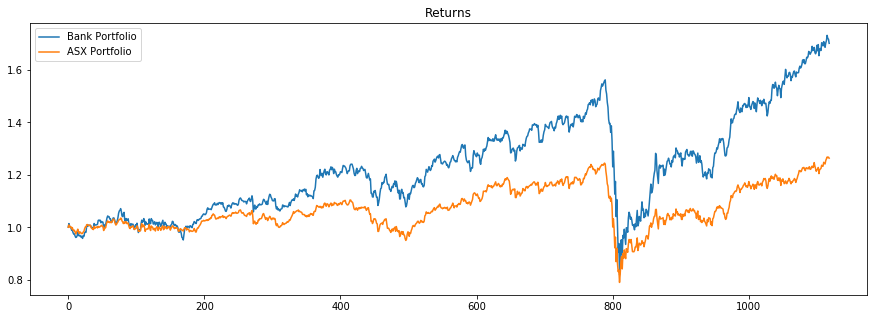

In [3]:
plt.figure(figsize=(15, 5))

for portfolio in [my_portfolio, asx_portfolio]:
    plt.plot(np.cumprod(np.exp(portfolio.returns/100)).values, label=portfolio.name)
plt.title('Returns')
plt.legend();

# Constrained Portfolio Optimization

In portfolio optimization we are trying to find a combination of stocks such that it both minimises the variance, but also maximises the returns. The typical constrained that one employs is that one can only have positive weighting of stocks, i.e. you can only be long on stocks not short.

In mathematical terms, portfolio optimization tries to solve the problem: consider an asset bundle
$$X_t = \sum_j\beta_jC_t^{(j)}+\bar{C}_t$$
where $C_t^{(j)}$ is the close of the j-th stock at time t, and $\bar{C}_t$ is the close of the current portfolio. We would like to solve
$$\min_{\beta_j}(\sigma^2 - \alpha \mu)$$
with the constrained that $\beta_j > 0$, for all $j$. Where $\sigma$ is the variance of the log-returns and $\mu$ is the mean of the log-returns.

Now, in the constrained portfolio optimization problem, consider that you only have a fixed amount, $k$, that you can invest with. Then the problem we would like to now solve is
$$\min_{\beta_j}(\sigma^2 - \alpha \mu)$$
with the constraint that 
$$\sum \beta_j C^{(j)}_T = k\quad \textrm{and}\ \beta_j > 0,\ \forall j $$
where $C^{(j)}_T$ is the last closing price of the $j$-th stock, i.e. the price at which we are buying the stock at.

To solve this problem, I use [projection gradient descent](https://angms.science/doc/CVX/CVX_PGD.pdf). The basic idea is that you want to employ gradient descent to minimise the normal optimization problem. But there is no guarantee that the new weights will satisfy the constraints. Projection gradient descent will then add an extra step to project the new weights back into the constraint, which can be done quite trivally.

In [4]:
def get_ticker_closing_values(ticker, start=START_DATE, end=END_DATE):
    ticker_history = yf.Ticker(ticker).history(start=start + timedelta(1), end=end)
    return ticker_history.loc[:, 'Close']

In [5]:
# One way to initialise the optimizer is to get the closing values yourself
tickers = ['JBH.AX', 'QUAL.AX', 'CIA.AX', 'CQR.AX', 'QBE.AX', 'CAR.AX', 'BVS.AX', 'MIN.AX', 'SGR.AX']

closing_values = np.stack([get_ticker_closing_values(ticker) for ticker in tickers]).T

current_portfolio_close = my_portfolio.close.values
portfolio_optimizer = ConstrainedPortfolioOptimization(tickers, closing_values=closing_values, 
                                                       current_portfolio_close=current_portfolio_close)

Important Parameters

    alpha - Controls the amount of risk. 
            If set to 0 then only the portfolio variance will be minimised 
            Larger values of alpha will increase the portfolio variance, but increase the returns
            
    epochs - The number of times gradient descent is performed
             Good idea to set this to as large of a number as you can
             
    learning_rate - Learning rate in gradient descent
                    Good idea to set this as small as you can, but 0.1 to 0.01 (inclusive) typically works well
                    
    sample_period - Float between 0 and 1
                    Here I set to 0.8, meaning that we will only perform the minimisation 
                    on the first 80% of the data
                    The algorithm will not optimize over the last 20%.
                    This allows you to forward test it on the most recent data

In [6]:
alpha = 0.01
max_portfolio_value = 5000  # Max amount to invest
sample_period = 0.8

# Here the code will get the closing prices for us
portfolio_optimizer = ConstrainedPortfolioOptimization(tickers, current_portfolio_close=current_portfolio_close)
results = portfolio_optimizer.get_best_ticker_combination(max_portfolio_value, epochs=40000, alpha=alpha, 
                                                          learning_rate=0.1, sample_period=sample_period, 
                                                          l1_reg=0, save_training_history=True)
ticker_shares, history = results

Since we are using gradient descent, you ideally would like to see flat lines for at lest the last 1000 epochs. If not, then you should increase the epochs, or increase the learning rate.

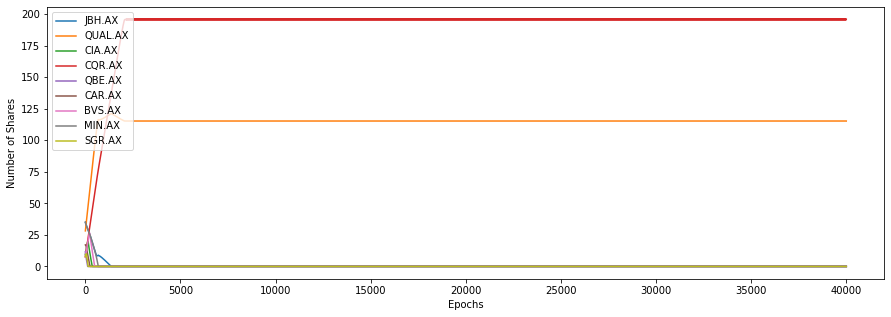

In [7]:
plt.figure(figsize=(15, 5))
for i, ticker in enumerate(tickers[:]):
    plt.plot(history.loc[:, ticker], label=ticker)
    
plt.ylabel('Number of Shares')
plt.xlabel('Epochs')
plt.legend(loc='upper left');

In [8]:
ticker_shares

,Units,Cost
JBH.AX,-0.000000,-0.00000
QUAL.AX,115.201879,4254.40542
CIA.AX,0.000000,0.00000
CQR.AX,195.694119,745.59458
QBE.AX,0.000000,0.00000
CAR.AX,0.000000,0.00000
BVS.AX,0.000000,0.00000
MIN.AX,0.000000,0.00000
SGR.AX,0.000000,0.00000


# Plots of Optimized Portfolio

You can see below the difference between the optimized (`new_portfolio`) and the old (`my_portfolio`) portfolio. The returns are equivalent, but you enjoy a significant reduction in the volatility.

In [9]:
ticker_names = list(ticker_shares.index)
ticker_costs = list(ticker_shares['Cost'].values)
new_portfolio = my_portfolio.add_tickers_to_portfolio(ticker_names, ticker_costs)

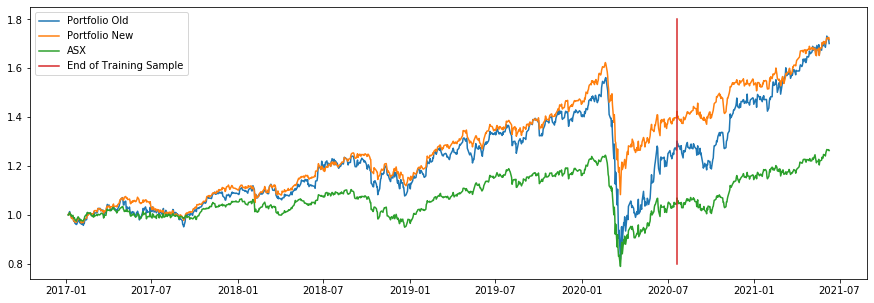

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(np.cumprod(np.exp(my_portfolio.returns/100)), label='Portfolio Old')
plt.plot(np.cumprod(np.exp(new_portfolio.returns/100)), label='Portfolio New')
plt.plot(np.cumprod(np.exp(asx_portfolio.returns/100)), label='ASX')

sample_length = int(len(new_portfolio.returns) * sample_period)
sampled_end_date = new_portfolio.close.index[sample_length]
plt.plot([sampled_end_date, sampled_end_date], [0.8, 1.8], label='End of Training Sample')
plt.legend();

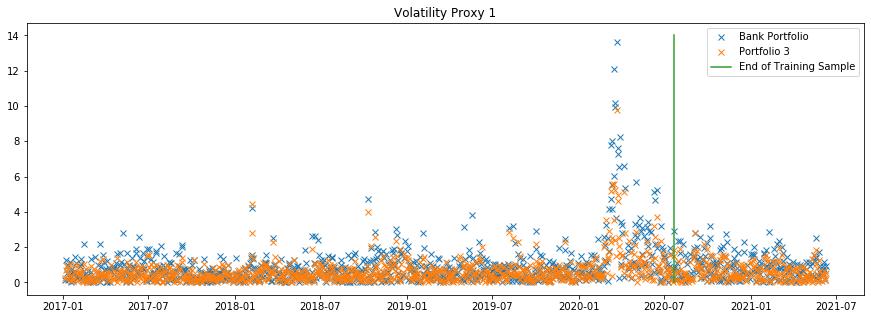

In [11]:
proxy = 1
plt.figure(figsize=(15, 5))

for portfolio in [my_portfolio, new_portfolio]:
    plt.plot(portfolio.volatility_proxy(proxy), 'x', label=portfolio.name)

plt.plot([sampled_end_date, sampled_end_date], [0, 14], label='End of Training Sample')
plt.title(f'Volatility Proxy {proxy}')
plt.legend();

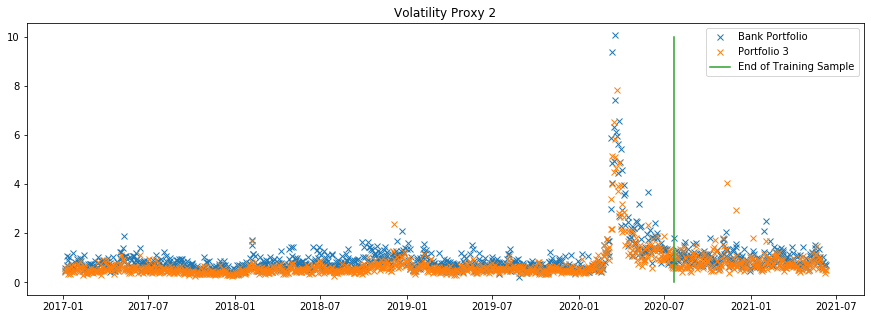

In [12]:
proxy = 2
plt.figure(figsize=(15, 5))

for portfolio in [my_portfolio, new_portfolio]:
    plt.plot(portfolio.volatility_proxy(proxy), 'x', label=portfolio.name)

plt.plot([sampled_end_date, sampled_end_date], [0, 10], label='End of Training Sample')
plt.title(f'Volatility Proxy {proxy}')
plt.legend();

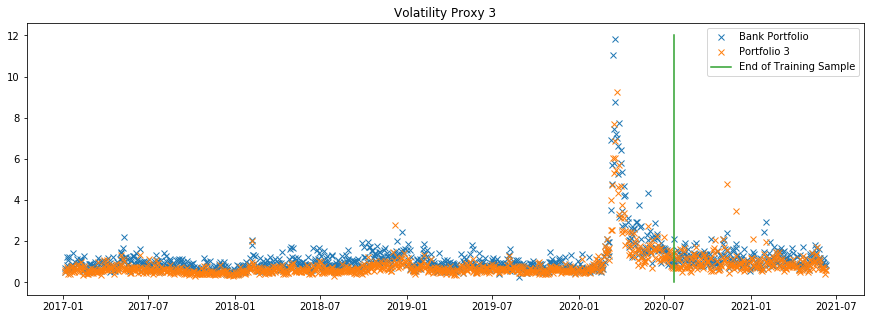

In [13]:
proxy = 3
plt.figure(figsize=(15, 5))

for portfolio in [my_portfolio, new_portfolio]:
    plt.plot(portfolio.volatility_proxy(proxy), 'x', label=portfolio.name)

plt.plot([sampled_end_date, sampled_end_date], [0, 12], label='End of Training Sample')
plt.title(f'Volatility Proxy {proxy}')
plt.legend();